# E5 Spectrogram classification 모델 구현

사람이 말하는 단어를 인공지능 모델로 구분해보자!

# Step 1. 데이터 처리와 분류

- 라벨 데이터 처리하기
- sklearn의 train_test_split함수를 이용하여 train, test 분리

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

데이터셋 살펴보기

In [2]:
print("Wave data shape : ", speech_data["wav_vals"].shape) # 1초 길이의 오디오 음성데이터 50620개/ 샘플레이트를 8000으로 재조정
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


In [4]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  24750
Wave data shape :  (8000,)
label :  ['go']


Label data 처리: 단어 정답은 텍스트 형태

In [6]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


텍스트 형의 라벨 데이터를 학습에 사용하기 위해 인덱스 형태로 바꿔주기 

In [7]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

학습을 위한 데이터 분리

In [9]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[ 1.01608486e-04  1.75380308e-04  3.08555173e-04 ...  9.74092254e-05
   2.05253120e-04  1.87803438e-04]
 [ 3.24528525e-03  4.86054178e-03  2.37491593e-04 ...  2.56886939e-03
   1.99823058e-03 -1.91366696e-03]
 [ 3.40051344e-03  4.84208483e-03  2.08958867e-04 ...  2.39678030e-03
   1.86608324e-03 -2.17993045e-03]
 ...
 [ 2.71860936e-05  1.03743783e-04 -2.74146645e-04 ... -4.30538566e-05
  -2.98737777e-05 -1.02644473e-04]
 [ 2.48308759e-03  2.30404618e-03  3.05005163e-03 ... -2.61422992e-03
  -2.99635599e-03 -3.32306139e-03]
 [ 3.29758250e-03  4.72782506e-03  1.16946110e-04 ...  8.75733420e-02
   9.84001905e-02  1.05232939e-01]]
✅


나눠진 데이터셋 확인

In [10]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)
✅


# Step 2. 학습을 위한 하이퍼파라미터 설정

모델 체크포인트 저장을 위한 체크포인트 경로 설정

In [11]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj20/aiffel/speech_recognition/models/wav'

# Step 3. 데이터셋 구성

- ```tf.data.Dataset```을 이용
- from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
- map과 batch를 이용한 데이터 전처리
map함수는 데이터셋이 데이터를 불러올 때마다 동작시킬 데이터 전처리 함수를 매핑해주는 역할.
첫번째 map함수는 from_tensor_slices에 입력한 튜플 형태로 데이터를 받으며 리턴 값으로 어떤 데이터를 반환할 지 결정. map함수는 중첩해서 사용가능.

- 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다. tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.

In [13]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


batch는 데이터셋에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수.

In [14]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


# Step 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

- 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
- batchnorm, dropout, dense layer 등을 이용
- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
- 모델 가중치를 저장하는 checkpoint callback 함수 추가
- 다양한 모델의 실험을 진행해 보시기 바랍니다.

## 1. Conv1D layer 적용

In [16]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 8000, 32)          320       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 4000, 32)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2000, 64)          0   

현재 라벨이 될 수 있는 단어는 12개. 이 12개의 클래스를 구분하기 위해서는 멀티 클래스 분류가 필요하기에 손실함수로 교차 엔트로피 오차를 사용.

In [17]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


트레이닝    
핏을 할 때, 콜백 함수를 사용해서 학습 중간중간 원하는 동작을 하도록 설정 가능.
모델 재사용을 위해 콜백 함수 추가

In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [22]:
# 배치 사이즈 32, 최대 에포크 10
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=1, # max_epochs
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

1423/1423 [==============================] - ETA: 0s - loss: 1.4371 - accuracy: 0.5190 ETA
Epoch 00001: val_loss improved from inf to 1.01336, saving model to /home/aiffel-dj20/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 148s 104ms/step - loss: 1.4371 - accuracy: 0.5190 - val_loss: 1.0134 - val_accuracy: 0.6877
✅


# Step 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

- loss, accuracy를 그래프로 표현

학습 결과 플롯    
트레이닝 로스와 발리데이션 로스의 차이가 커지느 경우 오버피팅이 일어나는 것이기에 수정이 필요.

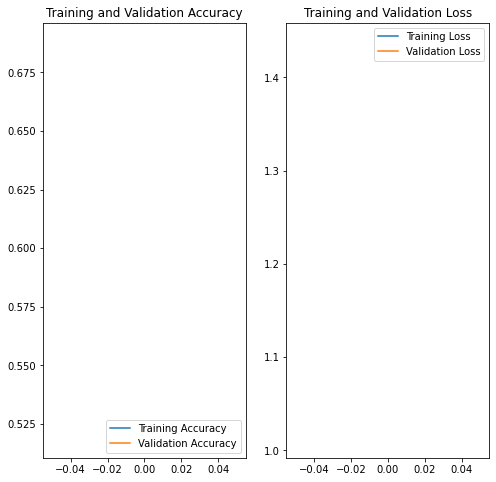

✅


In [23]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

테스트 데이터셋을 이용해서 모델의 성능을 평가.
시험삼아 체크포인트 콜백 함수가 저장한 가중치를 다시 불러와서 테스트 준비.

# Step 6. Test dataset을 이용해서 모델의 성능을 평가

- 저장한 weight 불러오기
- 모델의 예측값과 정답값이 얼마나 일치하는지 확인

예측값과 실제 값이 얼마나 일치하는지 확인하기. 

In [26]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [25]:
results = model_wav.evaluate(test_dataset)
print("✅")

159/159 [==============================] - 13s 79ms/step - loss: 1.0130 - accuracy: 0.6877
✅


In [28]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 1.013
accuracy value: 68.7673%
✅


테스트 데이터셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인.

In [30]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  yes


확인해본 테스트셋의 아벨과 우리 모델의 실제 예측 결과를 비교.

In [31]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: yes(Correct!)
✅


## 스킵커넥션

데이터가 레이어를 뛰어넘어 레이어를 통과한 값에 더해주는 형식으로 구현됨. concat을 이용한 방식으로 구현.

현재 사용하는 데이터는 1타원 오디오 데이터이기 때문에 1차원 데이터를 처리하는 모델을 구성.

In [32]:
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 8000, 32)     320         input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 8000, 32)     9248        conv1d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_8 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_21[0][0]                  
____________________________________________________________________________________________

In [33]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [34]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [35]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=1, # max_epochs
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

1423/1423 [==============================] - ETA: 0s - loss: 1.2441 - accuracy: 0.6003
Epoch 00001: val_loss improved from inf to 0.89342, saving model to /home/aiffel-dj20/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 188s 132ms/step - loss: 1.2441 - accuracy: 0.6003 - val_loss: 0.8934 - val_accuracy: 0.7227
✅


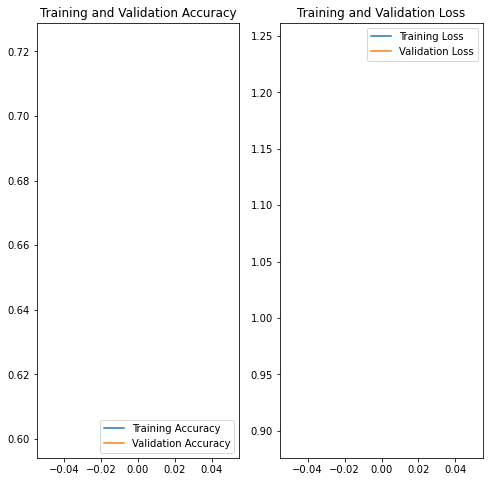

✅


In [36]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [37]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

159/159 [==============================] - 7s 46ms/step - loss: 0.8930 - accuracy: 0.7228
loss value: 0.893
accuracy value: 72.2837%
✅


In [38]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  stop


In [40]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: up(Incorrect!)
✅


음성 데이터를 1차원 시계열 데이터로 해석하는 waveform 해석을 통해 다루어옴.      
우리가 다루는 waveform은 많은 음원의 파형이 합성된 복합파임.    
푸리에 변환을 하면 다양한 파형들을 그 주파수 대역별로 나누어 별도로 해석 가능.

스펙토그램은 wav 데이터를 해석하는 방법 중 하나로 일정 시간동안 wav 데이터 안의 다양한 주파수들이 얼마나 포함되어 있는지를 보여줌.
STFT: 숏 타임 푸리에 트랜스폼. X축은 시간, Y축은 주파수를 나타내어 해당 시간/주파수에서 음파 강도에 따라 밝은색으로 표현됨.      
wav 데이터가 단위 시간만큼 STFT을 진행해 매 순간의 주파수 데이터를 얻어서 스펙토그램을 완성함. 

In [41]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [43]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


1차원 waveform 데이터가 2차원 스펙토그램으로 데이터 변환이 되어있음.    
waveform 데이터 대신 스펙토그램 포매스로 모든 음성 데이터를 변환 한 후 음성인식 모델을 학습시킨다면 과연 waveform과 비교했을 때 성능이 더 나을까?

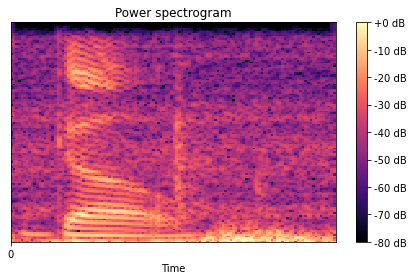

In [44]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

## Conv 2D Layer 적용

학습을 위한 데이터 분리

In [56]:
# 학습을 위한 데이터 분리
from sklearn.model_selection import train_test_split

sr = 8000  # 1초동안 재생되는 샘플의 갯수

train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

✅


나눠진 데이터 확인

In [57]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)
✅


학습을 위한 파라미터 설정

In [58]:
batch_size = 32
max_epochs = 1 # 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj20/aiffel/speech_recognition/models/wav'

데이터셋 구성

In [59]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [60]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


In [51]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

ValueError: Input 0 of layer conv2d_4 is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [None, 8000, 1]